## Theory

[Graph Convolutional Networks](https://arxiv.org/pdf/1609.02907)

### Introduction

The paper introduces a semi-supervised learning algorithm on graph-structured data, based on a variant of convolution that operates on graphs.

The main ideas from this paper rely on the assumption that connected nodes in the graph are likely to share the same label.

### Architecture

After the dimenssion of the features is reduced by the multiplication of feature matrix with the weight matrix, the next step is to multiply the result with the normalized adjacency matrix. The normalized adjacency matrix is important because:

1. **Capturing conectivity:** matrix $A$ encodes the connectivity information of the graph.
2. **Normalizing for node degrees:** by normalizing the adjacency matrix with $D$ (degree matrix), the influence of each neighboring node on a central node is scaled.
3. **Incorporating features:** after normalization, the resulting matri, reflects not only the connectivity between the nodes but also the importance of those connections relative to the degrees of the nodes involved


A multi-layer GCN has the following layer-wise propagation rule:
$$ H^{(l+1)} = \sigma\left(\widetilde{D}^{-\frac{1}{2}} \widetilde{A} \widetilde{D}^{-\frac{1}{2}} H^{(l)} W^{(l)}\right) $$

Where:
- $\widetilde{A}$ is the adjacency matrix of the undirected graph with added self-connections
- $\widetilde{D}$ is the degree matrix also with the self-connections
- $W^{(l)}$ layer-specific trainable weight matrix
- $\sigma$ activation function 
- $H^{(l)}$ is the matrix of activations in the $l^{(th)}$ layer, $ H^{(0)} = X $

In this paper were considered two GCN layers for node classification on a graph, the forward model takes the form:

$$Z = f(X, A) = softmax(\hat{A} ReLU(\hat{A} X W^{(0)}) W^{(1)})$$

Where $\hat{A}$ is:

$$\hat{A} = \widetilde{D}^{-\frac{1}{2}} \widetilde{A} \widetilde{D}^{-\frac{1}{2}}$$

The softmax activation function is applied row-wise. They evaluate the cross-entropy loss over all labeled examples. For training the weights they use Adam optimizer. Also there is a L2 regularization added to the first GCN layer.

## Code

### Data Loading

In [2]:
import torch
from torch_geometric.datasets import Planetoid
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
#Downloading the Cora dataset
dataset = Planetoid(root='./data', name='Cora')

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
data = dataset[0]
data.to(device)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [6]:
print(dataset)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Cora()
------------
Number of nodes: 2708
Number of graphs: 1
Number of features: 1433
Number of classes: 7


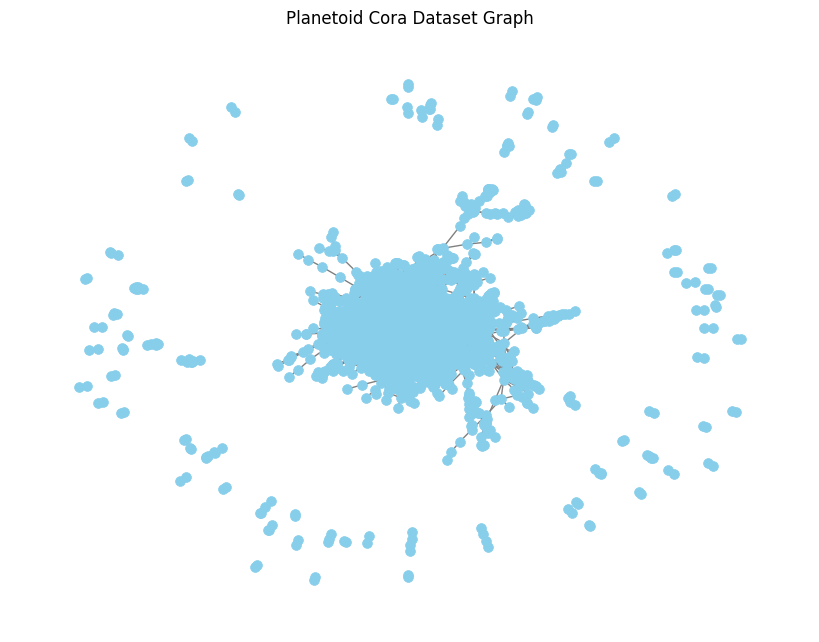

In [7]:
# Plotting the dataset

G = nx.Graph()
for i in range(data.edge_index.shape[1]):
    src, tgt = data.edge_index[:, i]
    G.add_edge(src.item(), tgt.item())

pos = nx.spring_layout(G)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=False, node_color='skyblue', node_size=50, edge_color='gray', linewidths=0.5)
plt.title('Planetoid Cora Dataset Graph')
plt.show()

### Building the model

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
from torchinfo import summary

In [9]:
#constants

EPOCHS = 200
L_RATE = 0.01

In [10]:
# GCN Layer
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features)) #compute our weights
        self.init_params() # initialize the weights with Xavier as in the paper

    def init_params(self):
        nn.init.xavier_uniform_(self.weight)
    
    def forward(self, x, adj_matrix):
        degree_matrix = adj_matrix.sum(dim=1)
        inv_degree_sqrt = torch.pow(degree_matrix, -0.5)
        #handling if there are zero degree nodes
        inv_degree_sqrt[inv_degree_sqrt == float('inf')] = 0
        norm_adj = adj_matrix * inv_degree_sqrt.view(-1, 1) * inv_degree_sqrt.view(1, -1)

        x = torch.matmul(norm_adj, x)
        x = torch.matmul(x, self.weight)

        return x

In [11]:
edge_index = data.edge_index

num_nodes = data.num_nodes

adj_matrix = torch.zeros((num_nodes, num_nodes))

for i in range(edge_index.shape[1]):
    src, tgt = edge_index[:, i]
    adj_matrix[src, tgt] = 1
    adj_matrix[tgt, src] = 1

In [12]:
layer = GCNLayer(in_features=data.num_features, out_features=16)

In [13]:
emb = layer(data.x, adj_matrix)

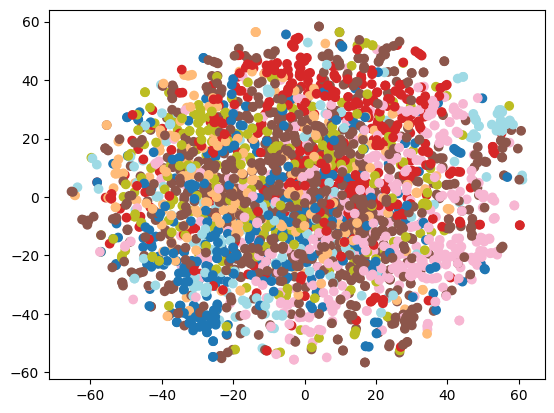

In [14]:
cora_color = data.y.cpu()

plt.scatter(
    *TSNE(n_components=2).fit_transform(emb.cpu().detach().numpy()).T,
    c=cora_color,
    cmap=plt.cm.tab20
)


plt.show()

In [15]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.gcn_layer1 = GCNLayer(in_features=in_features, out_features=64)
        self.gcn_layer2 = GCNLayer(in_features=64, out_features=64)
        self.fc = nn.Linear(in_features=64, out_features=out_features)

    def forward(self, x, adj_matrix):
        x = self.gcn_layer1(x, adj_matrix)
        x = F.relu(x)
        x = self.gcn_layer2(x, adj_matrix)
        x = F.relu(x)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)

        return x

gcnModel = GCN(in_features=dataset.num_features, out_features=dataset.num_classes)
summary(gcnModel)

Layer (type:depth-idx)                   Param #
GCN                                      --
├─GCNLayer: 1-1                          91,712
├─GCNLayer: 1-2                          4,096
├─Linear: 1-3                            455
Total params: 96,263
Trainable params: 96,263
Non-trainable params: 0

In [16]:
loss_fnc = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {"params": gcnModel.gcn_layer1.parameters(), "weight_decay": 0.001}, #L2 regularization for first layer
    {"params": gcnModel.gcn_layer2.parameters()},
    {"params": gcnModel.fc.parameters()}
], lr=L_RATE)

### Training & testing the model

In [17]:
from tqdm.notebook import tqdm

In [18]:
def train_epoch(model, data, train_idx, optimizer, loss_function, adj_matrix):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, adj_matrix)
    loss = loss_function(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()
    acc = (out[train_idx].argmax(dim=1) == data.y[train_idx]).sum().item() / train_idx.sum().item()
    return loss.item(), acc

@torch.no_grad()
def eval_epoch(model, data, mask, loss_function, adj_matrix):
    model.eval()
    out = model(data.x, adj_matrix)
    loss = loss_function(out[mask], data.y[mask])
    acc = (out[mask].argmax(dim=1) == data.y[mask]).sum().item() / mask.sum().item()
    return loss.item(), acc

In [19]:
EPOCHS = 200
loss_train_all = []
loss_val_all = []
acc_train_all = []
acc_val_all = []

for epoch in tqdm(range(1, EPOCHS + 1)):
    loss_train, acc_train = train_epoch(gcnModel, data, data.train_mask, optimizer, loss_fnc, adj_matrix)
    loss_val, acc_val = eval_epoch(gcnModel, data, data.val_mask, loss_fnc, adj_matrix)

    loss_train_all.append(loss_train)
    loss_val_all.append(loss_val)
    acc_train_all.append(acc_train)
    acc_val_all.append(acc_val)

    if epoch % 20 == 0:
        print(f"epoch = {epoch} | loss_train = {loss_train:.2f} acc_train = {acc_train:.2f} \t loss_val = {loss_val:.2f} acc_val = {acc_val:.2f}")


  0%|          | 0/200 [00:00<?, ?it/s]

epoch = 20 | loss_train = 0.00 acc_train = 1.00 	 loss_val = 1.20 acc_val = 0.75
epoch = 40 | loss_train = 0.00 acc_train = 1.00 	 loss_val = 1.02 acc_val = 0.76
epoch = 60 | loss_train = 0.00 acc_train = 1.00 	 loss_val = 0.86 acc_val = 0.77
epoch = 80 | loss_train = 0.00 acc_train = 1.00 	 loss_val = 0.85 acc_val = 0.77
epoch = 100 | loss_train = 0.00 acc_train = 1.00 	 loss_val = 0.85 acc_val = 0.78
epoch = 120 | loss_train = 0.00 acc_train = 1.00 	 loss_val = 0.87 acc_val = 0.77
epoch = 140 | loss_train = 0.00 acc_train = 1.00 	 loss_val = 0.88 acc_val = 0.77
epoch = 160 | loss_train = 0.00 acc_train = 1.00 	 loss_val = 0.89 acc_val = 0.77
epoch = 180 | loss_train = 0.00 acc_train = 1.00 	 loss_val = 0.90 acc_val = 0.77
epoch = 200 | loss_train = 0.00 acc_train = 1.00 	 loss_val = 0.91 acc_val = 0.77


In [20]:
#Plotting the loss & accuracy

def plot_loss(loss_train_all, loss_val_all, plot_title):
    epochs = range(1, len(loss_train_all) + 1)
    plt.plot(epochs, loss_train_all, 'b', label="Training loss")
    plt.plot(epochs, loss_val_all, 'r', label="Validation loss")
    plt.title(plot_title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_acc(acc_train_all, acc_val_all, plot_title):
    epochs = range(1, len(acc_train_all) + 1)
    plt.plot(epochs, acc_train_all, 'b', label="Training accuracy")
    plt.plot(epochs, acc_val_all, 'r', label="Validation accuracy")
    plt.title(plot_title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

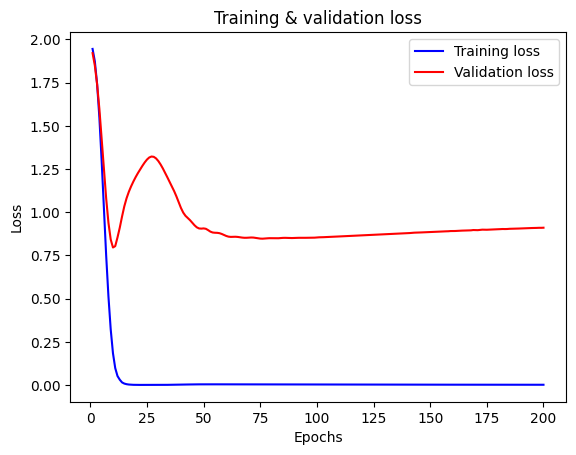

In [21]:
plot_loss(loss_train_all, loss_val_all, "Training & validation loss")

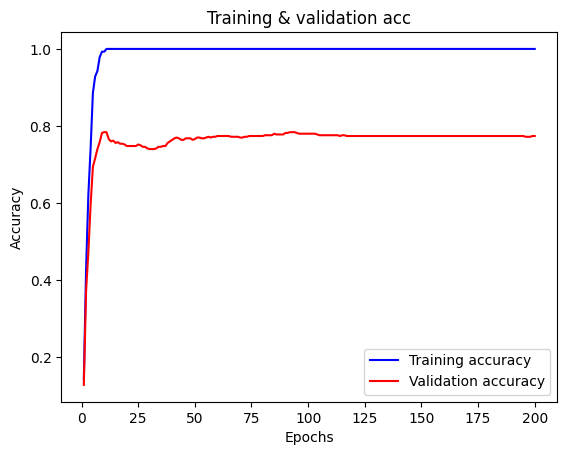

In [22]:
plot_acc(acc_train_all, acc_val_all, "Training & validation acc")

In [39]:
loss_test, acc_test = eval_epoch(gcnModel, data, data.test_mask, loss_fnc, adj_matrix)
print(f"Test set results: loss_test = {loss_test:.2f} acc_test = {acc_test:.2f}")

Test set results: loss_test = 0.83 acc_test = 0.78


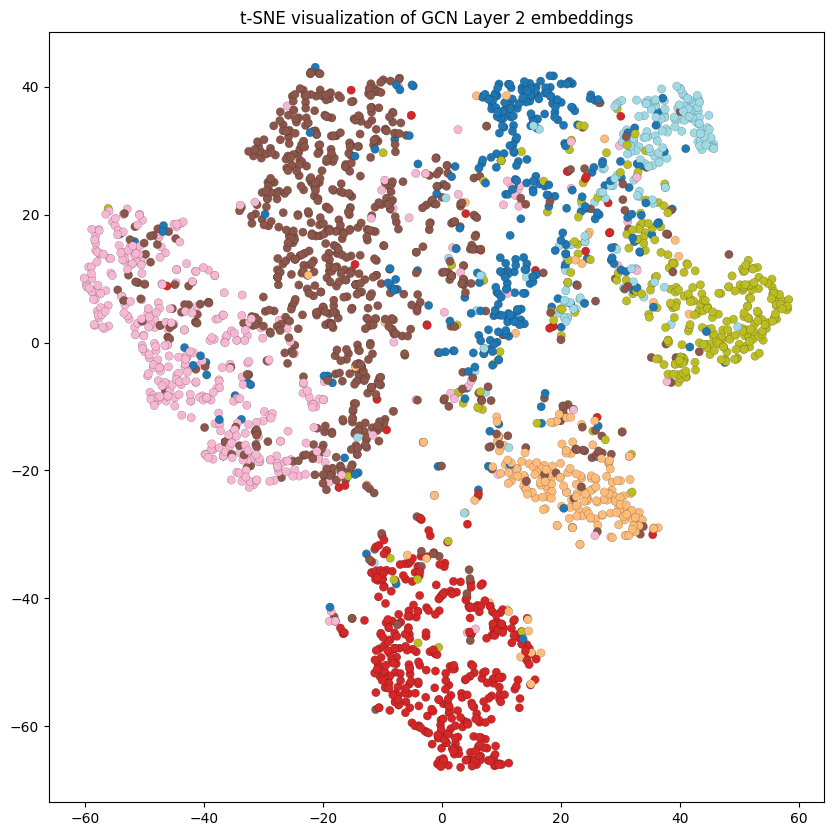

In [38]:
gcnModel.eval()

# Forward pass through the first and second GCN layers to get embeddings from the second layer
with torch.no_grad():
    x = data.x
    x = gcnModel.gcn_layer1(x, adj_matrix)
    x = F.relu(x)
    layer2_emb = gcnModel.gcn_layer2(x, adj_matrix)

# Convert embeddings and labels to numpy for plotting
emb_np = layer2_emb.cpu().detach().numpy()

# Perform t-SNE on the embeddings
tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(emb_np)

# Plotting
plt.figure(figsize=(10, 10))
plt.scatter(
    emb_2d[:, 0], emb_2d[:, 1], c=cora_color, cmap=plt.cm.tab20, edgecolors="black", linewidths=0.1
)
plt.title('t-SNE visualization of GCN Layer 2 embeddings')
plt.show()